## Imports


In [1]:
from google.colab import drive
# Mount Drive (idempotent in Colab)
# Request authorization to mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [88]:
# === Hybrid IDS: Step 1 (Load + Label + Prep) ===
# Works with plain CSVs and .csv.zip files in Google Drive (Colab)

# Import necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score, average_precision_score

from sklearn.model_selection import StratifiedShuffleSplit
import zipfile
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

# ------------------------ USER SETTINGS ------------------------
# Point this to your folder with the dataset files you listed
BASE_DIR = "/content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation"  # change if needed

# Accept both .csv and .csv.zip. You can also target a subfolder like ".../CMPE279-IDSandAttackMitigation/*.csv*"
DATA_GLOB = str(Path(BASE_DIR) / "*.csv")

# If you want to quickly test, limit rows per file (None = read all)
MAX_ROWS_PER_FILE: int | None = None
# ---------------------------------------------------------------


# ------------------------ LABEL/FEATURE CONFIG -----------------
ATTACK_KEYWORDS = [
    "DoS", "DDoS", "Hulk", "GoldenEye", "Slowloris", "HOIC", "LOIC", "LOIC-UDP"
]
LABEL_COL = "Label"

CANDIDATE_FEATURES = [
    "Flow Duration","Tot Fwd Pkts","Tot Bwd Pkts","TotLen Fwd Pkts","TotLen Bwd Pkts",
    "Fwd Pkt Len Mean","Bwd Pkt Len Mean","Fwd Pkt Len Std","Bwd Pkt Len Std",
    "Flow Byts/s","Flow Pkts/s","Fwd IAT Mean","Bwd IAT Mean","Flow IAT Mean",
    "Fwd IAT Std","Bwd IAT Std","Pkt Len Mean","Pkt Len Std","Pkt Len Var",
    "Fwd Header Len","Bwd Header Len","Down/Up Ratio","Bwd Pkts/b Avg","Fwd Pkts/b Avg",
    "Bwd Seg Size Avg","Fwd Seg Size Avg","Subflow Fwd Pkts","Subflow Bwd Pkts",
  "Subflow Fwd Byts","Subflow Bwd Byts",
    "Fwd Act Data Pkts","Idle Mean","Idle Std","Idle Max","Idle Min","Protocol","Dst Port"
]


LEAKY = ["Label","Timestamp","__source_file","Flow ID","Src IP","Dst IP","Src Port","y"]
RISKY = ["Dst Port","Protocol"]
RATE  = ["Flow Byts/s","Flow Pkts/s"]


OPTIONAL_FEATURES = ["SYN Flag Cnt","ACK Flag Cnt","PSH Flag Cnt","RST Flag Cnt","URG Flag Cnt"]

NON_FEATURE_COLS = {
    "Flow ID","Src IP","Dst IP","Src Port","Timestamp","TimeStamp","Source IP","Destination IP","Source Port"
}
# ---------------------------------------------------------------

In [154]:
import joblib
import os

# Define a fixed base directory for saving/loading models
MODEL_BASE_DIR = os.path.join(BASE_DIR, "saved_models")

def save_model(model, model_name):
    """Saves a trained model to a file using joblib with a fixed base path and extension."""
    os.makedirs(MODEL_BASE_DIR, exist_ok=True)
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    joblib.dump(model, filepath)
    print(f"Model '{model_name}' saved successfully to: {filepath}")

def load_model(model_name):
    """Loads a trained model from a file using joblib with a fixed base path and extension."""
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    if not os.path.exists(filepath):
        print(f"Error: Model file '{model_name}.joblib' not found at {filepath}")
        return None
    loaded_model = joblib.load(filepath)
    print(f"Model '{model_name}' loaded successfully from: {filepath}")
    return loaded_model

## Load Data

In [199]:
# Function definitions
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = []
    for col in props.columns:
        if props[col].dtype != object:

            props[col] = props[col].replace([np.inf, -np.inf], np.nan)


            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)

            else:
                props[col] = pd.to_numeric(props[col], errors="coerce")


    # df = reduce_mem_usage(df_raw)
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    print(props.info())
    return props, NAlist


def _read_csv(fpath: Path, max_rows: int | None) -> pd.DataFrame:
    """Read either .csv or .csv.zip into a DataFrame."""
    if str(fpath).endswith(".zip"):
        with zipfile.ZipFile(fpath, "r") as z:
            # pick the first .csv inside the zip
            inner_csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            if not inner_csvs:
                raise ValueError(f"No CSV found inside {fpath.name}")
            inner = inner_csvs[0]
            with z.open(inner) as fh:
                return pd.read_csv(fh, low_memory=False, nrows=max_rows)
    else:
        return pd.read_csv(fpath, low_memory=False, nrows=max_rows)

def load_cic_csvs(glob_pattern: str = DATA_GLOB,
                  max_rows_per_file: int | None = MAX_ROWS_PER_FILE, max_files=100) -> pd.DataFrame:
    files = sorted(Path(glob_pattern).parent.glob(Path(glob_pattern).name))
    if not files:
        raise FileNotFoundError(f"No files matched pattern: {glob_pattern}")

    dfs: List[pd.DataFrame] = []
    total_rows = 0
    print(f"Found {len(files[:max_files])} files. Loading...")
    for f in files[:max_files]:
        try:
            df = _read_csv(f, max_rows_per_file)
            df, _ = reduce_mem_usage(df)
            print(df.shape, _)
            df["__source_file"] = f.name
            dfs.append(df)
            total_rows += len(df)
            print(f"  • {f.name:40s} rows={len(df)}")
        except Exception as e:
            print(f"  ! Skipping {f.name} due to error: {e}")

    if not dfs:
        raise RuntimeError("No data could be loaded (all files failed).")
    out = pd.concat(dfs, ignore_index=True)
    print(f" Total rows loaded: {len(out)} from {len(dfs)} file(s)")
    return out



def label_binary(df: pd.DataFrame) -> pd.DataFrame:
    if LABEL_COL not in df.columns:
        # Some CIC exports use "Label" exactly; if not found, try case-insensitive match
        matches = [c for c in df.columns if c.lower() == "label"]
        if matches:
            df = df.rename(columns={matches[0]: LABEL_COL})
        else:
            raise KeyError(f"Column '{LABEL_COL}' not found in dataframe columns: {df.columns[:10].tolist()}...")

    labels = df[LABEL_COL].astype(str)
    is_attack = np.zeros(len(df), dtype=bool)
    for kw in ATTACK_KEYWORDS:
        is_attack |= labels.str.contains(kw, case=False, na=False)

    is_benign = labels.str.contains("BENIGN", case=False, na=False)
    keep = is_benign | is_attack

    df = df.loc[keep].copy()
    df["y"] = (is_attack & ~is_benign).astype(int)  # 1=attack, 0=benign
    return df


In [183]:
# 1) Quick visibility: list files in base dir (pythonic; avoids shell `!ls`)
print("Files in BASE_DIR:")
# List files only after successful drive mount
if os.path.exists(BASE_DIR):
    for name in sorted(os.listdir(BASE_DIR))[:50]:
        print("  ", name)
else:
    print(f"  ! {BASE_DIR} not found. Please ensure Google Drive is mounted and the path is correct.")

# 2) Load data (adjust DATA_GLOB above if your files are in a subfolder)
# Only attempt to load data if the base directory exists
if os.path.exists(BASE_DIR):
    df_raw = load_cic_csvs(DATA_GLOB, MAX_ROWS_PER_FILE, 3)

    # 3) Basic peek
    print("\nColumns (first 20):", df_raw.columns[:20].tolist())
    print("Example rows:")
    display(df_raw.head(3))
else:
    print("\nSkipping data loading and processing as BASE_DIR was not found.")

Files in BASE_DIR:
    IDS-HybridMode-Interim.ipynb
   .ipynb_checkpoints
   02-15-2018.csv
   02-15-2018.csv.zip
   02-16-2018.csv
   02-16-2018.csv.zip
   02-21-2018.csv
   02-21-2018.csv.zip
   GeneratedLabelledFlows.zip
   IDS- CMPE279CourseProject.docx
   IDS.ipynb
   Untitled0.ipynb
   saved_models
Found 3 files. Loading...
Memory usage of properties dataframe is : 639.9995155334473  MB


/tmp/ipython-input-3519068148.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  props[col].fillna(mn-1,inplace=True)
/tmp/ipython-input-3519068148.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  240.9998960494995  MB
This is  37.65626226273362 % of the initial size
(1048575, 80) ['Flow Byts/s', 'Flow Pkts/s']
  • 02-15-2018.csv                           rows=1048575
Memory usage of properties dataframe is : 639.9995155334473  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  639.9995155334473  MB
This is  100.0 % of the initial size
(1048575, 80) []
  • 02-16-2018.csv                           rows=1048575
Memory usage of properties dataframe is : 639.9995155334473  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  238.99989795684814  MB
This is  37.34376232420096 % of the initial size
(1048575, 80) []
  • 02-21-2018.csv                           rows=1048575
 Total rows loaded: 3145725 from 3 file(s)

Columns (first 20): ['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd 

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source_file
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0.0,0.0,0,0,56320580.0,704.278381,56321077,56320081,Benign,02-15-2018.csv
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,1024353.0,649038.75,1601183,321569,11431221.0,3644990.5,15617415,8960247,Benign,02-15-2018.csv
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,02-15-2018.csv


## Train Test Split


In [181]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145725 entries, 0 to 3145724
Data columns (total 81 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Dst Port           object
 1   Protocol           object
 2   Timestamp          object
 3   Flow Duration      object
 4   Tot Fwd Pkts       object
 5   Tot Bwd Pkts       object
 6   TotLen Fwd Pkts    object
 7   TotLen Bwd Pkts    object
 8   Fwd Pkt Len Max    object
 9   Fwd Pkt Len Min    object
 10  Fwd Pkt Len Mean   object
 11  Fwd Pkt Len Std    object
 12  Bwd Pkt Len Max    object
 13  Bwd Pkt Len Min    object
 14  Bwd Pkt Len Mean   object
 15  Bwd Pkt Len Std    object
 16  Flow Byts/s        object
 17  Flow Pkts/s        object
 18  Flow IAT Mean      object
 19  Flow IAT Std       object
 20  Flow IAT Max       object
 21  Flow IAT Min       object
 22  Fwd IAT Tot        object
 23  Fwd IAT Mean       object
 24  Fwd IAT Std        object
 25  Fwd IAT Max        object
 26  Fwd IAT Min   

In [197]:
import pandas as pd

# Convert to datetime if not already
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])

# Group by day name and count
weekday_counts = df_raw.groupby(df_raw['Timestamp'].dt.day_name()).size().reset_index(name='count')

print(weekday_counts)

/tmp/ipython-input-1619171322.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])


ValueError: time data "Timestamp" doesn't match format "%d/%m/%Y %H:%M:%S", at position 37039. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [203]:
df = label_binary(df_raw)
# print("\nLabel counts (0=benign, 1=attack):")
# print(df["y"].value_counts(dropna=False))
# df.dropna(inplace=True)
# df.drop_duplicates(inplace = True)

safe_cols = [
    "Dst Port", "Protocol",
    "Fwd Pkt Len Max", "Fwd Pkt Len Min",
    "Bwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd PSH Flags", "Bwd PSH Flags",
    "Fwd URG Flags", "Bwd URG Flags",
    "FIN Flag Cnt", "SYN Flag Cnt", "RST Flag Cnt",
    "PSH Flag Cnt", "ACK Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt",
    "Fwd Seg Size Min",
    "Fwd Header Len", "Bwd Header Len"
]
df = df[safe_cols + ['y','Timestamp']]
df.drop_duplicates(inplace = True)


df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)
df = df.sort_values("Timestamp").reset_index(drop=True)
df = df.drop(columns=["Timestamp"])
# df, _ = reduce_mem_usage(df)

TARGET = "y"
for c in df.columns:
    if c != TARGET:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

df.info()

# 3) cast all model features to float32 (simple, uniform)
# feat_cols = [c for c in df.columns if c != TARGET]
# df[feat_cols] = df[feat_cols].astype("float32")



/tmp/ipython-input-4168065706.py:23: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664425 entries, 0 to 1664424
Data columns (total 22 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   Dst Port          1664425 non-null  int64
 1   Protocol          1664425 non-null  int64
 2   Fwd Pkt Len Max   1664425 non-null  int64
 3   Fwd Pkt Len Min   1664425 non-null  int64
 4   Bwd Pkt Len Max   1664425 non-null  int64
 5   Bwd Pkt Len Min   1664425 non-null  int64
 6   Fwd PSH Flags     1664425 non-null  int64
 7   Bwd PSH Flags     1664425 non-null  int64
 8   Fwd URG Flags     1664425 non-null  int64
 9   Bwd URG Flags     1664425 non-null  int64
 10  FIN Flag Cnt      1664425 non-null  int64
 11  SYN Flag Cnt      1664425 non-null  int64
 12  RST Flag Cnt      1664425 non-null  int64
 13  PSH Flag Cnt      1664425 non-null  int64
 14  ACK Flag Cnt      1664425 non-null  int64
 15  URG Flag Cnt      1664425 non-null  int64
 16  CWE Flag Count    1664425 non-null  

In [204]:
# --- DEFINE FEATURES AND LABEL ---
X = df.drop(columns=["y"])
X = X[safe_cols]
y = df["y"]

split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- SHAPES ---
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# --- OPTIONAL: Check label distribution ---
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))

X_train: (1331540, 21)
X_test: (332885, 21)
y_train: (1331540,)
y_test: (332885,)

Train label distribution:
y
0    0.962799
1    0.037201
Name: proportion, dtype: float64

Test label distribution:
y
0    0.991426
1    0.008574
Name: proportion, dtype: float64


In [205]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331540 entries, 0 to 1331539
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   Dst Port          1331540 non-null  int64
 1   Protocol          1331540 non-null  int64
 2   Fwd Pkt Len Max   1331540 non-null  int64
 3   Fwd Pkt Len Min   1331540 non-null  int64
 4   Bwd Pkt Len Max   1331540 non-null  int64
 5   Bwd Pkt Len Min   1331540 non-null  int64
 6   Fwd PSH Flags     1331540 non-null  int64
 7   Bwd PSH Flags     1331540 non-null  int64
 8   Fwd URG Flags     1331540 non-null  int64
 9   Bwd URG Flags     1331540 non-null  int64
 10  FIN Flag Cnt      1331540 non-null  int64
 11  SYN Flag Cnt      1331540 non-null  int64
 12  RST Flag Cnt      1331540 non-null  int64
 13  PSH Flag Cnt      1331540 non-null  int64
 14  ACK Flag Cnt      1331540 non-null  int64
 15  URG Flag Cnt      1331540 non-null  int64
 16  CWE Flag Count    1331540 non-null  

**Reasoning**:
Create the final code cell for visualization.



## Visualization


Overall counts (0=benign, 1=attack):
y
0    1612037
1      52388
Name: count, dtype: int64

Overall % (0=benign, 1=attack):
y
0    96.85
1     3.15
Name: count, dtype: float64


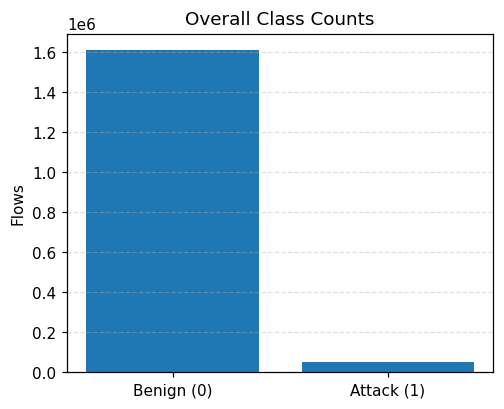

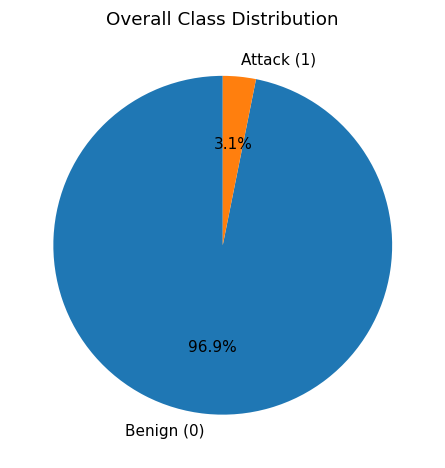

In [185]:
# === Overall class balance: bar + pie ===
if 'df' in locals():
    overall_counts = df["y"].value_counts().reindex([0, 1], fill_value=0)
    overall_pct = (overall_counts / overall_counts.sum() * 100).round(2)

    print("Overall counts (0=benign, 1=attack):")
    print(overall_counts)
    print("\nOverall % (0=benign, 1=attack):")
    print(overall_pct)

    # Bar chart
    plt.figure(figsize=(5,4), dpi=110)
    plt.bar(["Benign (0)", "Attack (1)"], overall_counts.values)
    plt.title("Overall Class Counts")
    plt.ylabel("Flows")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

    # Pie chart
    plt.figure(figsize=(5,5), dpi=110)
    plt.pie(overall_counts.values, labels=["Benign (0)", "Attack (1)"], autopct="%1.1f%%", startangle=90)
    plt.title("Overall Class Distribution")
    plt.show()
else:
    print("\nSkipping visualization as df was not created.")

# Training Models


## Random Forest

In [19]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

model = RandomForestClassifier(
    n_estimators=75,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', # Changed 'auto' to 'sqrt'
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=1,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [ ]:

# clf = GridSearchCV(
#     estimator=model,
#     param_grid=hyperparameters,
#     cv=5,
#     verbose=3,
#     n_jobs=-1  # Use all available CPU cores
# )

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model.fit(X=X_train, y=y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [22]:
save_model(model, "random_forest_model_cpu")

Model 'random_forest_model_cpu' saved successfully to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/random_forest_model_cpu.joblib


### Cuda Random Forest


In [9]:
# make sure runtime is GPU
!nvidia-smi

# install RAPIDS stack
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Mon Oct 27 00:50:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [213]:
from sklearn.model_selection import GridSearchCV
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
import cudf
import cupy as cp

# Define the cuML Random Forest model
rf_model_gpu = cuRandomForestClassifier(
    random_state=42,
    n_estimators=75,
    max_features="sqrt",
    max_depth=20,

    )

# Define the hyperparameters grid
hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
    # Add other hyperparameters you want to tune
}

# Set up GridSearchCV
clf_gpu = GridSearchCV(
    estimator=rf_model_gpu,
    param_grid=hyperparameters,
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1 # Use all available CPU cores (or GPUs if configured by cuML)
)

# Fit GridSearchCV on your training data (X_train and y_train should be on the GPU)
# Note: Ensure X_train and y_train are cuDF DataFrames or cuPy arrays for best performance on GPU

# Convert pandas DataFrame and numpy array to cuDF DataFrame and cuPy array
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu  = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series(y_train.values.astype(np.int32))

rf_model_gpu.fit(X_train_gpu, y_train_gpu)



p_test_gpu_df = rf_model_gpu.predict_proba(X_test_gpu)   # cuDF DataFrame
p_test_gpu = p_test_gpu_df.values # Convert to cuPy array
p_test = cp.asnumpy(p_test_gpu)[:, 1]                              # numpy, select positive class probabilities
y_hat  = (p_test >= 0.5).astype(int)

In [215]:

p = p_test  # probabilities as numpy array

# sanity: see score range
print("p_test min/max:", float(np.min(p)), float(np.max(p)))

prec, rec, thr = precision_recall_curve(y_test, p)
# For each threshold thr[i], the corresponding precision/recall are prec[i+1], rec[i+1]
prec_t = prec[1:]
rec_t  = rec[1:]
thr_t  = thr

# 1) choose threshold for recall >= target with best precision
target_recall = 0.98
mask = rec_t >= target_recall
if mask.any():
    # among thresholds that meet recall, pick the one with highest precision
    idx = np.argmax(prec_t[mask])
    thr_star = thr_t[mask][idx]
else:
    # target unreachable; fall back to threshold that gets recall closest to target
    idx = np.argmin(np.abs(rec_t - target_recall))
    thr_star = thr_t[idx]

y_thr = (p >= thr_star).astype(int)
print(f"\nChosen threshold: {thr_star:.6f}  (recall target {target_recall})")
print("Confusion @thr*\n", confusion_matrix(y_test, y_thr))
print("\nReport @thr*\n", classification_report(y_test, y_thr, digits=4))

# 2) optional: pure F1-max threshold
f1_t = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)
i_f1 = np.nanargmax(f1_t)
thr_f1 = thr_t[i_f1]
y_f1 = (p >= thr_f1).astype(int)
print(f"\nF1-max threshold: {thr_f1:.6f}")
print("Confusion @F1\n", confusion_matrix(y_test, y_f1))
print("\nReport @F1\n", classification_report(y_test, y_f1, digits=4))

# keep your summary metrics
print("\nROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:",  average_precision_score(y_test, p))

p_test min/max: 0.00029833317967131734 0.6827483177185059

Chosen threshold: 0.005120  (recall target 0.98)
Confusion @thr*
 [[  1432 328599]
 [     0   2854]]

Report @thr*
               precision    recall  f1-score   support

           0     1.0000    0.0043    0.0086    330031
           1     0.0086    1.0000    0.0171      2854

    accuracy                         0.0129    332885
   macro avg     0.5043    0.5022    0.0129    332885
weighted avg     0.9915    0.0129    0.0087    332885


F1-max threshold: 0.043845
Confusion @F1
 [[329807    224]
 [   854   2000]]

Report @F1
               precision    recall  f1-score   support

           0     0.9974    0.9993    0.9984    330031
           1     0.8993    0.7008    0.7877      2854

    accuracy                         0.9968    332885
   macro avg     0.9483    0.8500    0.8930    332885
weighted avg     0.9966    0.9968    0.9966    332885


ROC-AUC: 0.7017086566735783
PR-AUC: 0.6428214233703273


In [216]:
from sklearn.metrics import average_precision_score, roc_curve
print("PR-AUC:", average_precision_score(y_test, p_test))

# recall at 1% FPR
fpr, tpr, thr = roc_curve(y_test, p_test)
i = np.argmin(np.abs(fpr - 0.01))
print(f"@1% FPR -> recall={tpr[i]:.4f}, thr={thr[i]:.6f}")

PR-AUC: 0.6428214233703273
@1% FPR -> recall=0.7008, thr=0.018997


In [ ]:
save_model(model_gpu, "random_forest_gpu_model")

In [22]:
# loaded_model = load_model("random_forest_model")

## XGBoost



In [226]:
import numpy as np
import pandas as pd
import cudf
import cupy as cp
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, precision_recall_curve
)

# assume you already have pandas: X_train, X_test, y_train, y_test
# move to GPU
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu  = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series(y_train.values.astype(np.int32))

# class imbalance
pos_rate = float(y_train.mean())
scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-9)

model_xgb_gpu = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    predictor="gpu_predictor",
    eval_metric="logloss",
    eta=0.05,
    max_depth=8,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=1200
)

# train with eval_set for early stopping
model_xgb_gpu.fit(
    X_train_gpu, y_train_gpu,
    eval_set=[(X_train_gpu, y_train_gpu)],
    verbose=False
)

# probabilities on GPU
p_test_gpu = model_xgb_gpu.predict_proba(X_test_gpu)[:, 1]   # cupy array
p_test = cp.asnumpy(p_test_gpu)                              # numpy
y_hat  = (p_test >= 0.5).astype(int)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [224]:
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score
fpr, tpr, thr = roc_curve(y_test, p_test)
i = (abs(fpr - 0.01)).argmin()   # 1% FPR
thr_1pct = thr[i]
y_1pct = (p_test >= thr_1pct).astype(int)

print("thr_1pct:", thr_1pct)
print("recall@1%FPR:", recall_score(y_test, y_1pct))
print("precision@1%FPR:", precision_score(y_test, y_1pct))

f1_t = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)
i_f1 = np.nanargmax(f1_t)
thr_f1 = thr_t[i_f1]
y_f1 = (p >= thr_f1).astype(int)
print(f"\nF1-max threshold: {thr_f1:.6f}")
print("Confusion @F1\n", confusion_matrix(y_test, y_f1))
print("\nReport @F1\n", classification_report(y_test, y_f1, digits=4))

thr_1pct: 0.018996703
recall@1%FPR: 0.700770847932726
precision@1%FPR: 0.7945967421533572

F1-max threshold: 0.043845
Confusion @F1
 [[329807    224]
 [   854   2000]]

Report @F1
               precision    recall  f1-score   support

           0     0.9974    0.9993    0.9984    330031
           1     0.8993    0.7008    0.7877      2854

    accuracy                         0.9968    332885
   macro avg     0.9483    0.8500    0.8930    332885
weighted avg     0.9966    0.9968    0.9966    332885



In [ ]:
save_model(model_xgb_gpu, "xboost_gpu")

### Inference and metrics


# Ngrok
